# Problemas de trabajo práctico: Sesiones de doblaje
## Autor
Miguel Ángel Álvarez Cabanes
## Github
https://github.com/maalvarezcabanes/algoritmos_optimizacion

## Importación paquetes y funciones auxiliares

In [557]:
import pandas as pd
import random
import os
import logging

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

logging.basicConfig(level=logging.INFO)
logging.getLogger().setLevel(logging.INFO)

In [558]:
show_expanded_solution = True

In [559]:
def clean_plot(ax, xlabel, ylabel, title, legend = True, rotate = 45):
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if legend:
        ax.legend(bbox_to_anchor=(1.2, 1))
    if rotate:
        ax.tick_params(axis='x', labelrotation = rotate)

## Enunciado
Se precisa coordinar el doblaje de una película. Las reglas de planificación que se deben seguir son:
1. Los actores del doblaje deben coincidir en las tomas en las que sus personajes aparecen juntos en las diferentes tomas.
2. Los actores de doblaje cobran todos la misma cantidad por cada día que deben desplazarse hasta el estudio de grabación independientemente del número de tomas que se graben.
3. No es posible grabar más de 6 tomas por día.
4. El objetivo es planificar las sesiones por día de manera que el gasto por los servicios de los actores de doblaje sea el menor posible.

## Lectura de datos de tomas y actores
Los datos originales están en https://docs.google.com/spreadsheets/d/1Ipn6IrbQP4ax8zOnivdBIw2lN0JISkJG4fXndYd27U0/edit#gid=0, pero los descargo a un fichero "doblaje.xlsx" por comodidad.

A continuación leo los datos con pandas limpiando el DataFrame para solo quedarme con los datos de actores y tomas

In [560]:
df = pd.read_excel(os.path.join(".", "doblaje.xlsx"), skiprows=1).drop(["Unnamed: 11", "Total"], axis=1)
df.set_index("Toma", inplace=True)
df.drop("TOTAL", inplace=True)
df.dropna(inplace=True)
df

,1,2,3,4,5,6,7,8,9,10
Toma,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
5,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
7,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
8,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Mínimo coste hipotético
Para establecer un mínimo coste hipotético, voy a sumar las sesiones de cada actor y lo voy a dividir entre seis. Hipotéticamente si los actores pudiesen grabar las sesiones de forma independiente, la suma de esos costes sería el mínimo. Es probable que esa solución no sea factible, pero sabemos seguro que ninguna solución va a ser mejor que esa.

In [561]:
uso_total_actores = df.sum()
display(uso_total_actores)
coste_minimo_actor = -(uso_total_actores // -6)
display(coste_minimo_actor)
coste_minimo = int(sum(coste_minimo_actor))
display(coste_minimo)

1     22.0
2     14.0
3     13.0
4     15.0
5     11.0
6      8.0
7      3.0
8      4.0
9      2.0
10     2.0
dtype: float64

1     4.0
2     3.0
3     3.0
4     3.0
5     2.0
6     2.0
7     1.0
8     1.0
9     1.0
10    1.0
dtype: float64

21

En el mejor de los casos sabemos que no vamos a conseguir un coste menor que 21.

In [562]:
def analyze_solution(df, info_dias):
    coste_minimo_actor = -(df.sum() // -6)
    dias_actores = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    uso_actores_solucion = [x[0] for x in info_dias]
    for dias in uso_actores_solucion:
        for i, actor in enumerate(dias):
            if actor:
                dias_actores[i] += 1
    i = 1
    for minimo, uso in zip(coste_minimo_actor, dias_actores):
        if int(minimo) == uso:
            print(f"Hemos logrado el coste mínimo para el actor número {i}. Coste: {uso}")
        else:
            print(f"Para el actor {i} hemos logrado un coste: {uso}. El mínimo hipotético sería {int(minimo)}")
        i += 1

## Planteamiento inicial: Solución naïve
Para la representación de datos voy a crear una lista de días, y cada uno de los días va a estar representado por otra lista de escenas que se ruedan ese día.

La solución naïve consistiría en elegir por orden en grupos de seis tomas por día, por lo que el máximo de días debería ser cinco. Voy a crear esta solución inicial ya que puede ser usada como una referencia de "peor solución".

Nota: Voy a tratar de hacer el código usando el menor número posible de funcionalidades de librerías para tratar de que la algoritmia usada quede lo más visible posible. Por comodidad sí usaré el DataFrame para acceder a la información.

In [563]:
def print_solucion(df, dias, coste, info_dias, show_expanded_solution = False):
    if show_expanded_solution:
        i = 1
        for dia, info in zip(dias, info_dias):
            print(f"Dia: {i}")
            print(f"Sesiones: {dia}")
            print(f"Uso actores: {info[0]}")
            print(f"Coste día: {info[1]}\n")
            i += 1
                                
    print(f"Solucion: {dias}")
    print(f"Coste total: {coste}")

In [564]:
def coste_dia(df, sesiones):
    coste = 0
    uso_actores = [sum(row) for index, row in df.loc[sesiones].T.iterrows()]
    for uso_actor in uso_actores:
        if uso_actor:
            coste += 1
    return (uso_actores, coste)

In [565]:
def coste_total(df, dias):
    coste = 0
    info_dias = []
    for num_dia, dia in enumerate(dias):
        (uso_actores, coste_aux) = coste_dia(df, dia)
        info_dias.append((uso_actores, coste_aux))
        coste += coste_aux
    return (info_dias, coste)

In [566]:
def solucion_naive(df, max_dias = 5):
    sesiones = list(df.index)
    dias = []
    for i in range(max_dias):
        dias.append(sesiones[max_dias*i: max_dias*(i+1)])
    
    return (dias, coste_total(df, dias))

In [567]:
dias_naive, (info_dias_naive, coste_naive) = solucion_naive(df)
print_solucion(df, dias_naive, coste_naive, info_dias_naive, show_expanded_solution = show_expanded_solution)

Dia: 1
Sesiones: [1, 2, 3, 4, 5]
Uso actores: [2.0, 4.0, 2.0, 3.0, 3.0, 0.0, 2.0, 2.0, 0.0, 0.0]
Coste día: 7

Dia: 2
Sesiones: [6, 7, 8, 9, 10]
Uso actores: [5.0, 5.0, 0.0, 3.0, 2.0, 2.0, 0.0, 0.0, 1.0, 0.0]
Coste día: 6

Dia: 3
Sesiones: [11, 12, 13, 14, 15]
Uso actores: [5.0, 3.0, 3.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0, 0.0]
Coste día: 8

Dia: 4
Sesiones: [16, 17, 18, 19, 20]
Uso actores: [3.0, 0.0, 4.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0]
Coste día: 6

Dia: 5
Sesiones: [21, 22, 23, 24, 25]
Uso actores: [3.0, 2.0, 3.0, 2.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0]
Coste día: 7

Solucion: [[1, 2, 3, 4, 5], [6, 7, 8, 9, 10], [11, 12, 13, 14, 15], [16, 17, 18, 19, 20], [21, 22, 23, 24, 25]]
Coste total: 34


In [568]:
df2 = pd.DataFrame([["naïve", len(dias_naive), coste_naive]], columns = ["Algoritmo", "Numero dias", "Coste"])
df2

,Algoritmo,Numero dias,Coste
0,naïve,5,34


### Conclusiones
Como se puede observar, la solución requiere tres días de rodaje y un coste de 34 unidades.

## Aproximación voraz (I)
En esta aproximación voy a ir asignando las sesiones de forma ordenada escogiendo siempre la primera que "quepa" en el día y relegando a días posteriores las que no.

In [569]:
def coste_sesion_voraz(df, uso_actores, nueva_sesion, limite):
    posible_uso_actores = [sum(row) for row in zip(uso_actores, list(df.loc[nueva_sesion]))]
    logging.debug(f"Posible nueva sesion: {nueva_sesion}.")
    logging.debug(f"Posible uso de actores: {posible_uso_actores}. Max {max(posible_uso_actores)}")
    if max(posible_uso_actores) > limite:
        return None
    else:
        return 0

In [570]:
def mejor_sesion(df, sesiones_dia, sesiones, limite, func_coste_sesion = coste_sesion_voraz):
    logging.debug(f"Sesiones dia: {sesiones_dia}.")
    uso_actores = [sum(row) for index, row in df.loc[sesiones_dia].T.iterrows()]
    lista_costes = []
    for j in sesiones:
        lista_costes.append((func_coste_sesion(df, uso_actores, j, limite=limite), j))
    mejor = (2000, None)
    for z in lista_costes:
        if (z[0] != None) and (z[0] < mejor[0]):
            mejor = z
    return mejor[1]

In [571]:
def algoritmo_basico(df, sesiones, coste_sesion = coste_sesion_voraz, limite = 6):
    dias = []
    i = 0
    while len(sesiones):
        dias.append([])
        while True:
            nueva_sesion = mejor_sesion(df, dias[i], sesiones, limite=limite)
            if nueva_sesion == None:
                i += 1
                break
            dias[i].append(nueva_sesion)
            sesiones.remove(nueva_sesion)
    
    logging.debug(f"Solucion: {dias}")
              
    return (dias, coste_total(df, dias))

In [572]:
sesiones = list(df.index)
dias_voraz, (info_dias_voraz, coste_voraz) = algoritmo_basico(df, sesiones)
print_solucion(df, dias_voraz, coste_voraz, info_dias_voraz, show_expanded_solution = show_expanded_solution)

Dia: 1
Sesiones: [1, 2, 3, 4, 5, 6, 7, 13, 14, 18, 21, 24]
Uso actores: [6.0, 6.0, 5.0, 6.0, 6.0, 4.0, 2.0, 3.0, 0.0, 0.0]
Coste día: 8

Dia: 2
Sesiones: [8, 9, 10, 11, 12, 15, 16, 27]
Uso actores: [6.0, 6.0, 2.0, 4.0, 2.0, 3.0, 1.0, 1.0, 1.0, 1.0]
Coste día: 10

Dia: 3
Sesiones: [17, 19, 20, 22, 23, 25]
Uso actores: [6.0, 2.0, 5.0, 3.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
Coste día: 6

Dia: 4
Sesiones: [26, 28, 29, 30]
Uso actores: [4.0, 0.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0]
Coste día: 6

Solucion: [[1, 2, 3, 4, 5, 6, 7, 13, 14, 18, 21, 24], [8, 9, 10, 11, 12, 15, 16, 27], [17, 19, 20, 22, 23, 25], [26, 28, 29, 30]]
Coste total: 30


In [573]:
df2.loc[df2.shape[0]] = ["voraz", len(dias_voraz), coste_voraz]
df2

,Algoritmo,Numero dias,Coste
0,naïve,5,34
1,voraz,4,30


Aunque consigo una solución mejor que la "naïve", en el fondo es fácil observar que en cierta manera pasa algo similar a una aproximación voraz con el problema de la mochila (aunque en este caso minimizando en lugar de maximizando)... es fáci observar que los actores 7, 8, 9, y 10 (que son los que tienen menos carga de trabajo total) han repartido su trabajo en varios días en lugar de concentrarlo.

## Aproximación voraz (II)
Para esta aproximación, voy a usar una nueva función de coste para el algoritmo voraz. Básicamente voy a potenciar la posibilidad de dejar el máximo hueco posible en el día para nuevas sesiones.

In [574]:
def coste_sesion_voraz2(df, uso_actores, nueva_sesion, limite):
    posible_uso_actores = [sum(row) for row in zip(uso_actores, list(df.loc[nueva_sesion]))]
    logging.debug(f"Posible nueva sesion: {nueva_sesion}.")
    logging.debug(f"Posible uso de actores: {posible_uso_actores}. Max {max(posible_uso_actores)}")
    return limite - max(posible_uso_actores)

In [575]:
sesiones = list(df.index)
dias_voraz2, (info_dias_voraz2, coste_voraz2) = algoritmo_basico(df, sesiones, coste_sesion = coste_sesion_voraz2)
print_solucion(df, dias_voraz2, coste_voraz2, info_dias_voraz2, show_expanded_solution = show_expanded_solution)

Dia: 1
Sesiones: [1, 2, 3, 4, 5, 6, 7, 13, 14, 18, 21, 24]
Uso actores: [6.0, 6.0, 5.0, 6.0, 6.0, 4.0, 2.0, 3.0, 0.0, 0.0]
Coste día: 8

Dia: 2
Sesiones: [8, 9, 10, 11, 12, 15, 16, 27]
Uso actores: [6.0, 6.0, 2.0, 4.0, 2.0, 3.0, 1.0, 1.0, 1.0, 1.0]
Coste día: 10

Dia: 3
Sesiones: [17, 19, 20, 22, 23, 25]
Uso actores: [6.0, 2.0, 5.0, 3.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
Coste día: 6

Dia: 4
Sesiones: [26, 28, 29, 30]
Uso actores: [4.0, 0.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0]
Coste día: 6

Solucion: [[1, 2, 3, 4, 5, 6, 7, 13, 14, 18, 21, 24], [8, 9, 10, 11, 12, 15, 16, 27], [17, 19, 20, 22, 23, 25], [26, 28, 29, 30]]
Coste total: 30


In [576]:
df2.loc[df2.shape[0]] = ["voraz2", len(dias_voraz2), coste_voraz2]
df2

,Algoritmo,Numero dias,Coste
0,naïve,5,34
1,voraz,4,30
2,voraz2,4,30


## Aproximación voraz con arranque experto
Me pregunto qué pasaría si aplicamos la misma solución, pero ordenando primero las secuencias de forma que las primeras sean las que están los actores menos usados, de forma que tiendan a agruparse sus escenas.

El orden "lógico" sería 10, 9, 7, 8, 6, 5, 3, 4, 2, 1 poniendo por orden inverso de uso de actores, pero usando 10, 9, 8, 7, 6, 5, 4, 3, 2, 1 consigo 26 en lugar de 27.

In [577]:
def reordenar_sesiones(sesiones, orden_actores):
    sesiones_ordered = []
    for actor in orden_actores:
        for sesion in sesiones:
            if df.loc[sesion][actor]:
                sesiones_ordered.append(sesion)
                sesiones.remove(sesion)
    return sesiones_ordered

In [578]:
sesiones = list(df.index)
orden_actores = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
sesiones_reordenadas = reordenar_sesiones(sesiones, orden_actores)
dias_voraz_experto, (info_dias_voraz_experto, coste_voraz_experto) = algoritmo_basico(df, sesiones_reordenadas, coste_sesion = coste_sesion_voraz2)
print_solucion(df, dias_voraz_experto, coste_voraz_experto, info_dias_voraz_experto, show_expanded_solution = show_expanded_solution)

Dia: 1
Sesiones: [16, 25, 10, 26, 4, 11, 21, 3, 15, 18, 24, 27, 2]
Uso actores: [6.0, 6.0, 5.0, 4.0, 5.0, 4.0, 3.0, 3.0, 2.0, 2.0]
Coste día: 10

Dia: 2
Sesiones: [8, 12, 14, 29, 1, 6, 5]
Uso actores: [6.0, 5.0, 3.0, 4.0, 3.0, 4.0, 0.0, 1.0, 0.0, 0.0]
Coste día: 7

Dia: 3
Sesiones: [13, 20, 7, 22, 28, 17]
Uso actores: [6.0, 2.0, 3.0, 5.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Coste día: 5

Dia: 4
Sesiones: [23, 9, 30]
Uso actores: [3.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Coste día: 4

Solucion: [[16, 25, 10, 26, 4, 11, 21, 3, 15, 18, 24, 27, 2], [8, 12, 14, 29, 1, 6, 5], [13, 20, 7, 22, 28, 17], [23, 9, 30]]
Coste total: 26


In [579]:
df2.loc[df2.shape[0]] = ["voraz_experto", len(dias_voraz_experto), coste_voraz_experto]
df2

,Algoritmo,Numero dias,Coste
0,naïve,5,34
1,voraz,4,30
2,voraz2,4,30
3,voraz_experto,4,26


Creo que la utilización de este punto de partida ha sido muy acertado. Está claro que la forma en la que he implementado la voracidad está muy condicionada por el punto de partida.

## Aproximación voraz multiarranque
Esta aproximación es añternativa a la que he denominado "voraz2", ya que en lugar de ordenar de forma intencionada las sesiones con un determinado criterio, voy a buscar otros puntos de partida utilizando un multiarranque barajando el orden de inicio de las sesiones

In [583]:
def algoritmo_multiarranque(df, sesiones, intentos, max_dias = 5):
    dias_voras_multi, coste_voraz_multi = dias_naive, coste_naive # :TODO: Chequear si pasarlo como parámetro
    for i in range(intentos):
        sesiones_aux = sesiones.copy()
        random.shuffle(sesiones_aux)
        logging.debug(f"Orden sesiones: {sesiones_aux}")
        dias_aux, (info_aux, coste_aux) = algoritmo_basico(df, sesiones_aux)
        logging.debug(f"Coste voraz: {coste_aux}")
        if coste_aux < coste_voraz_multi:
            dias_voras_multi, (info_voraz_multi, coste_voraz_multi) = dias_aux, (info_aux, coste_aux)
            
    return (dias_voras_multi, (info_voraz_multi, coste_voraz_multi))

In [584]:
sesiones = list(df.index)
dias_voraz_multi, (info_dias_voraz_multi, coste_voraz_multi) = algoritmo_multiarranque(df, sesiones, 20)
print_solucion(df, dias_voraz_multi, coste_voraz_multi, info_dias_voraz_multi, show_expanded_solution = show_expanded_solution)

Dia: 1
Sesiones: [26, 11, 2, 8, 14, 20, 10, 27, 5, 24, 21, 3, 16]
Uso actores: [6.0, 5.0, 6.0, 5.0, 6.0, 5.0, 1.0, 3.0, 2.0, 1.0]
Coste día: 10

Dia: 2
Sesiones: [17, 22, 12, 29, 19, 23, 18]
Uso actores: [6.0, 2.0, 6.0, 2.0, 1.0, 3.0, 0.0, 0.0, 0.0, 0.0]
Coste día: 6

Dia: 3
Sesiones: [28, 6, 4, 25, 15, 9]
Uso actores: [6.0, 5.0, 0.0, 4.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0]
Coste día: 7

Dia: 4
Sesiones: [30, 1, 7, 13]
Uso actores: [4.0, 2.0, 1.0, 4.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Coste día: 5

Solucion: [[26, 11, 2, 8, 14, 20, 10, 27, 5, 24, 21, 3, 16], [17, 22, 12, 29, 19, 23, 18], [28, 6, 4, 25, 15, 9], [30, 1, 7, 13]]
Coste total: 28


In [585]:
df2.loc[df2.shape[0]] = ["voraz_multi", len(dias_voraz_multi), coste_voraz_multi]
df2

,Algoritmo,Numero dias,Coste
0,naïve,5,34
1,voraz,4,30
2,voraz2,4,30
3,voraz_experto,4,26
4,voraz_multi,4,29
5,voraz_multi,4,28


Ni siquiera con un número "alto" de arranques (200) consigo resultados mejores que los de la ordenación inicial dirigida que he llamado "voraz2". En el fondo tiene sentido, ya que estoy permutando 30 elementos, por lo que el espacio de posibilidades es 30! La posibilidad de encontrarme con una ordenación inicial interesante es mínima

## Aproximación con búsqueda local de actores
Como he mencionado antes al reordenar las secuencias según el uso de actores, he conseguido mejores resultados con una ordenación que no era exactamente la que habría sido "lógica" usando una ordenación por uso de actores. Sin embargo, curiosamente la que he usado al final podría haberse obtenido como una exploración local de la otra.

Voy a explorar algo más esa idea implementando un algoritmo de búsqueda local en ese sentido. Voy a dejar que se intercambien actores con una o dos posiciones de diferencia con respecto al orden inicial. 

In [586]:
def busqueda_local_actores(df, sesiones, orden_actores, coste_sesion = coste_sesion_voraz):
    sesiones_copy = sesiones.copy()
    sesiones_reordenadas = reordenar_sesiones(sesiones_copy, orden_actores)
    dias_voraz_ref, (info_dias_voraz_ref, coste_voraz_ref) = algoritmo_basico(df, sesiones_reordenadas, coste_sesion = coste_sesion)
    for j in range(2):
        for i in range(len(orden_actores)-1-j):
            orden_aux = orden_actores.copy()
            orden_aux[i], orden_aux[i+1+j] = orden_aux[i+1+j], orden_aux[i]
            sesiones_copy = sesiones.copy()
            sesiones_reordenadas = reordenar_sesiones(sesiones_copy, orden_aux)
            dias_voraz_aux, (info_dias_voraz_aux, coste_voraz_aux) = algoritmo_basico(df, sesiones_reordenadas, coste_sesion = coste_sesion)
            if coste_voraz_aux < coste_voraz_ref:
                print(f"Nuevo orden de actores: {orden_aux}")
                dias_voraz_ref, (info_dias_voraz_ref, coste_voraz_ref) = dias_voraz_aux, (info_dias_voraz_aux, coste_voraz_aux)
                orden_actores = orden_aux
    return (dias_voraz_ref, (info_dias_voraz_ref, coste_voraz_ref))

In [587]:
sesiones = list(df.index)
orden_actores = [10, 9, 7, 8, 6, 5, 3, 4, 2, 1]
dias_local, (info_dias_local, coste_local) = busqueda_local_actores(df, sesiones, orden_actores)
print_solucion(df, dias_local, coste_local, info_dias_local, show_expanded_solution = show_expanded_solution)

Nuevo orden de actores: [10, 9, 7, 8, 6, 5, 4, 3, 2, 1]
Nuevo orden de actores: [10, 9, 7, 8, 6, 5, 4, 1, 2, 3]
Dia: 1
Sesiones: [16, 25, 10, 26, 3, 15, 4, 11, 21, 18, 24, 27, 2]
Uso actores: [6.0, 6.0, 5.0, 4.0, 5.0, 4.0, 3.0, 3.0, 2.0, 2.0]
Coste día: 10

Dia: 2
Sesiones: [8, 12, 14, 29, 1, 6, 5]
Uso actores: [6.0, 5.0, 3.0, 4.0, 3.0, 4.0, 0.0, 1.0, 0.0, 0.0]
Coste día: 7

Dia: 3
Sesiones: [13, 20, 7, 22, 28, 9]
Uso actores: [6.0, 3.0, 2.0, 6.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Coste día: 5

Dia: 4
Sesiones: [19, 30, 17]
Uso actores: [3.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Coste día: 3

Solucion: [[16, 25, 10, 26, 3, 15, 4, 11, 21, 18, 24, 27, 2], [8, 12, 14, 29, 1, 6, 5], [13, 20, 7, 22, 28, 9], [19, 30, 17]]
Coste total: 25


In [588]:
df2.loc[df2.shape[0]] = ["local_actores", len(dias_local), coste_local]
df2

,Algoritmo,Numero dias,Coste
0,naïve,5,34
1,voraz,4,30
2,voraz2,4,30
3,voraz_experto,4,26
4,voraz_multi,4,29
5,voraz_multi,4,28
6,local_actores,4,25


Con un arranque desde un punto inteligente + algortimo voraz + búsqueda local hemos conseguido mejorar del coste 34 de la solución "naïve" a 25. Sin embargo, seguimos sin llegar al míninimo coste hipotético.

En cualquier momento puede ser interesante analizar para qué actores no hemos logrado el mínimo coste hipotético.

In [589]:
analyze_solution(df, info_dias_local)

Hemos logrado el coste mínimo para el actor número 1. Coste: 4
Hemos logrado el coste mínimo para el actor número 2. Coste: 3
Para el actor 3 hemos logrado un coste: 4. El mínimo hipotético sería 3
Para el actor 4 hemos logrado un coste: 4. El mínimo hipotético sería 3
Para el actor 5 hemos logrado un coste: 3. El mínimo hipotético sería 2
Hemos logrado el coste mínimo para el actor número 6. Coste: 2
Hemos logrado el coste mínimo para el actor número 7. Coste: 1
Para el actor 8 hemos logrado un coste: 2. El mínimo hipotético sería 1
Hemos logrado el coste mínimo para el actor número 9. Coste: 1
Hemos logrado el coste mínimo para el actor número 10. Coste: 1


En este punto me planteo tres caminos para seguir:
1. Nueva búsqueda local centrada en los actores para los que no he conseguido el mínimo.
2. Definir una nueva función de voracidad usando una métrica de distancia diferente de la actual (que básicamente con el reordenamiento de sesiones no deja de ser un relleno primero los que tienen menos carga)
3. El mejor algoritmo hasta el momento es determinista. La inclusión de diversificación a la hora de seleccionar el punto de partida no ha ayudado, pero me pregunto si podemos ganar algo aleatorizando un tanto la función de voracidad.

En el siguiente apartado voy a tratar de abordar 2 y 3 al mismo tiempo mediante un grasp.

## GRASP + nueva métrica de distancia

Para la función de distancia voy a potenciar la posibilidad de ir completando las sesiones de los actores, por tanto, para cada sesión voy a considerar como coste el coste residual del actor que se quedaría con menos sesiones pendientes. Para evitar puntos muertos, el coste de una sesión va a ser 1000 si no es factible.

Para el grasp lo que voy a hacer es seleccionar el número de mejores opciones de coste entre las cuales quiero aleatorizar la selección.

In [ ]:
def distancia(df, dia, sesion):
    

In [ ]:
def solucion_voraz2(df, sesiones, max_dias = 5):
    dias = []
    to_remove = []
    for i in range(max_dias):
        logging.debug(f"Sesiones: {sesiones}")
        logging.debug(f"Usadas en iteracion anterior: {to_remove}")
        for z in to_remove:
            sesiones.remove(z)
        to_remove = []
        while add_new_ses
        for j in sesiones:
            if len(dias) < i+1:
                dias.append([j])
                to_remove.append(j)
            else:
                if chequear_factibilidad(df, dias[i], j):
                    dias[i].append(j)
                    to_remove.append(j)
    
    logging.debug(f"Solucion: {dias}")
              
    return (dias, coste_total(df, dias))

In [ ]:
sesiones = list(df.index)
orden_actores = [10, 9, 7, 8, 6, 5, 3, 4, 2, 1]
dias_local, (info_dias_local, coste_local) = busqueda_local_actores(df, sesiones, orden_actores, func_voraz = solucion_voraz2)
print_solucion(df, dias_local, coste_local, info_dias_local, show_expanded_solution = show_expanded_solution)

## Conclusiones

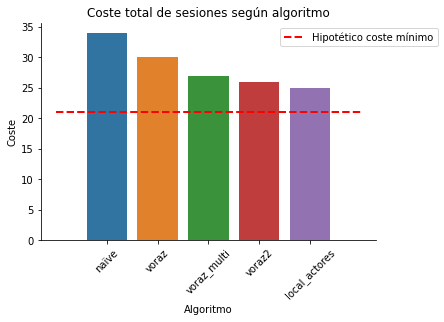

In [273]:
ax = sns.barplot(data = df2.sort_values(by="Coste", ascending=False), x="Algoritmo", y="Coste")
ax.hlines(y=coste_minimo, xmin=-1, xmax=5, linewidth=2, linestyle="--", color='r', label = "Hipotético coste mínimo")
clean_plot(ax, "Algoritmo", "Coste", "Coste total de sesiones según algoritmo")
plt.show();